# The sensitivity analysis in pyPowsybl 

In this notebook, you will learn how to run a sensitivity analysis on a network using pypowsybl.

This type of analysis allows to study the sensitivity of state variables to small fluctuations in a variable. As an example, we can examine the impact of varying the active power of a generator in the active power flow on the branches surrounding this generator. 

It is also possible to calculate Power Transfer Distribution Factors (PTDF). In this case, zones are defined and the effect of the variation of the net position of a zone on a branch between this zone and another one.

The first step is to import the library.

In [1]:
import pypowsybl as pp

We will consider the six buses example network in this notebook. It is available directly in the pyPowsybl library.

In [2]:
n6 = pp.network.create_metrix_tutorial_six_buses_network()

By drawing the network area diagram, you can get a better understanding of the substations and branches in the network.

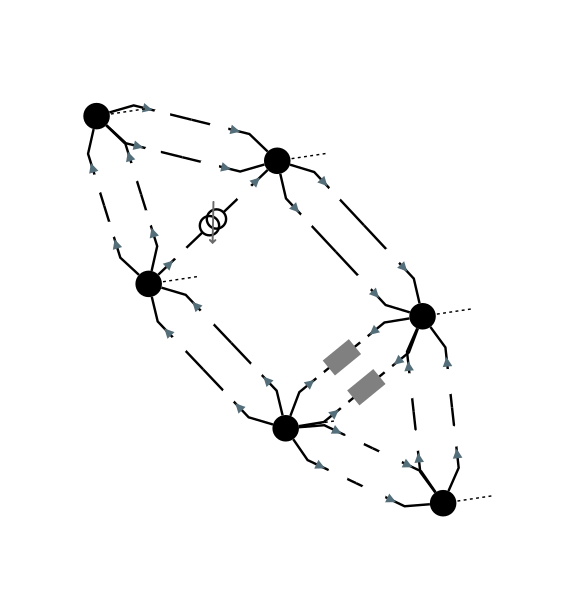

In [3]:
n6.get_network_area_diagram()

## 1 - The sensitivity analysis

To perform a sensitivity analysis, the first thing to do is define the “factors” you want to compute. 
What we call a factor is the impact of a small variation of a variable, typically the active power injection of a generator, a load or a phase shifter, on a function, typically the active power flow on a branch.

To make the definition of those factors easier, `pypowsybl` provides a method to define the variables (injection, phase shifter) through their ids (variables_ids) and the functions through the branch ids (branches_ids). We obtain a matrix of sensitivities as a result.
First, let's create the analysis:

In [4]:
analysis = pp.sensitivity.create_dc_analysis()

Now let's create the factors. We are going to study the impact on the active power flow of `S_SO_1` and `S_SO_2` of a variation of the active power injection of the generator `SE_G`.
`S_SO_1` and `S_SO_2` are the two lines connecting the substations `S` and `SO` and `SE_G` is the generator in the substation `SE`.
To define these factors, you just need to give their IDs to the creation function like this:

In [5]:
analysis.add_branch_flow_factor_matrix(branches_ids=['S_SO_1', 'S_SO_2'], variables_ids=['SE_G'])

Now you can run the analysis with:

In [6]:
result = analysis.run(n6)

Let's examine the results of the sensitivity analysis. First, we can have a look at the reference matrix. It contains the flows on the previously defined branches according to the load flow.

In [7]:
result.get_reference_matrix()

,S_SO_1,S_SO_2
reference_values,-120.433341,-120.433341


Now, we can look at the sensitivity matrix, which shows how the active power flow of the two lines changes when the generator's active power changes.

In [8]:
result.get_sensitivity_matrix()

,S_SO_1,S_SO_2
SE_G,0.26087,0.26087


An increase of 1 MW on generator `SE_G` has the effect of increasing the active power flow from side 1 to side 2 by 0.26 MW on the lines `S_SO_1` and `S_SO_2`.

## 2 - Zone to zone sensitivity: PTDF computation

This zone-to-zone sensitivity feature is also known as Power Transfer Distribution Factor, or PTDF for short.

Now, imagine that the node `SE`, is in Italy and the other nodes are in France. 
We can update the `TSO` and `country` field of the substations.

In [9]:
n6b = pp.network.create_metrix_tutorial_six_buses_network()
n6b.update_substations(id=['SE'], TSO=['Terna'], country=['IT'])
n6b.update_substations(id=['NO', 'S', 'SO', 'N'], TSO=['RTE', 'RTE', 'RTE', 'RTE'], country=['FR', 'FR', 'FR', 'FR'])

We can run a load flow:

In [10]:
pp.loadflow.run_dc(n6b)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=0, reference_bus_id='NE_poste_0', slack_bus_results=[SlackBusResult(id='NE_poste_0', active_power_mismatch=4.440892098500626e-14)], distributed_active_power=-100.00000000000004)]

In the dataframe with the substation information, the `TSO` and `country` columns are now filled.

In [11]:
n6b.get_substations()

,name,TSO,geo_tags,country
id,,,,
NO,,RTE,,FR
S,,RTE,,FR
SO,,RTE,,FR
SE,,Terna,,IT
N,,RTE,,FR


Now we can create two zones for the sensitivity analysis: one for France and one for Italy:

In [12]:
zone_fr = pp.sensitivity.create_country_zone(n6b, 'FR')
zone_it = pp.sensitivity.create_country_zone(n6b, 'IT')

We can examine the shift keys for the zone representing France. They're linked to the active power setpoint of the generators:

In [13]:
zone_fr.shift_keys_by_injections_ids

{'SO_G1': 480.0, 'SO_G2': 480.0, 'N_G': 0.0}

Let's create the analysis and set the zones to the two we previously declared.

In [14]:
params = pp.loadflow.Parameters(distributed_slack=False)
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])

And we can create the factor matrix again. This time, we're looking at how changing the net position of the two zones, `FR` and `IT`, affects the active power flow of the lines `S_SE_1` and `S_SE_2`.

In [15]:
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2'], variables_ids=['FR', 'IT'])

We can run the analysis and get the sensitivity matrix.

In [16]:
ptdf_results = sa.run(n6b, params)
m1 = ptdf_results.get_branch_flows_sensitivity_matrix()
m1

,S_SE_1,S_SE_2
FR,0.2,0.2
IT,-0.1,-0.1


Transferring 1 MW of active power from the zone `FR` to the zone `IT` will cause a 0.3 MW shift on border line `S_SE_1`.

Let’s obtain that directly. After running a sensitivity analysis to figure out the best zones, we can request a `FR` zone to slack sensitivity, a `FR` to `IT` zone to zone sensitivity, an `IT` to `FR` zone to zone sensitivity, and an `IT` zone to slack sensitivity on all the border lines `S_SE_1`, `S_SE_2`, `SE_NE_1` and `SE_NE_2`.

In [17]:
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2', 'SE_NE_1', 'SE_NE_2'], variables_ids=['FR', ('FR', 'IT'), ('IT', 'FR'), 'IT'])
ptdf_result = sa.run(n6b, params)

In [18]:
m2 = ptdf_result.get_branch_flows_sensitivity_matrix()
m2

,S_SE_1,S_SE_2,SE_NE_1,SE_NE_2
FR,0.2,0.2,0.2,0.2
FR -> IT,0.3,0.3,-0.2,-0.2
IT -> FR,-0.3,-0.3,0.2,0.2
IT,-0.1,-0.1,0.4,0.4


We can see that:
- an increase of 1 MW on the `FR` zone net position leads to an increase of 0.2 MW on the flow of all the border lines.
- moving the flow of 1 MW from `FR` to `IT` leads to an increase of 0.3 MW on the flow of lines `S_SE_1` and `S_SE_2` and a decrease of 0.2 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.
- moving the flow of 1 MW from `IT` to `FR` leads to a decrease of 0.3 MW on the flow of lines `S_SE_1` and `S_SE_2` and an increase of 0.2 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.
- an increase of 1 MW on the `IT` zone net position leads to a decrease of 0.1 MW on the flow of lines `S_SE_1` and `S_SE_2` and an increase of 0.4 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.